# HLY1801 CTD Data

In [1]:
import pandas as pd
from seabird.cnv import fCNV
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

DEBUG:matplotlib:CACHEDIR=C:\Users\maceadmin\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\maceadmin\.matplotlib\fontlist-v300.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
# Read in all of the .cnv files from the HLY
files = glob('../../data/ctdData/HLY1801/*.cnv')
profile = fCNV(files[0])
print(profile.attributes)
print(profile.keys())

{'sbe_model': '9', 'LATITUDE': 64.6705, 'LONGITUDE': -168.23416666666665, 'gps_datetime': 'Aug 08 2018 09:19:55', 'seasave': 'V 7.26.7.107', 'instrument_type': 'CTD', 'nquan': '20', 'nvalues': '35', 'start_time': 'Jan 01 2000 09:19:55 [NMEA time, first data scan]', 'bad_flag': '-9.990e-29', 'file_type': 'ascii', 'md5': 'c43ec79467229723dbda4694eeb56186', 'datetime': datetime.datetime(2000, 1, 1, 9, 19, 55), 'filename': 'HLY1801_001.cnv'}
['PRES', 'DEPTH', 'TEMP', 'TEMP2', 'c0mS/cm', 'c1mS/cm', 'flECO-AFL', 'CStarTr0', 'soundspeed', 'altM', 'scan', 'oxigenvoltage', 'sbeox1V', 'timeS', 'PSAL', 'PSAL2', 'oxigen_ml_L', 'sbeox1ML/L', 'nbin', 'flag']


In [3]:
# For each file, lets pull out the location, and the average temp, salinity, fluorometer reading, 
# and seabird calculated sound speed from below 2 meters (saildrone draft is 1.94) to the bottom
lat = []
lon = []
dt = []
temp = []
sal = []
ss = []
flo = []
for file in files:
    profile = fCNV(file)
    lat.append(profile.attributes.get('LATITUDE'))
    lon.append(profile.attributes.get('LONGITUDE'))
    dt.append('gps_datetime')
    temp.append(np.mean(profile.data[2][profile.data[1] > 2]))
    sal.append(np.mean(profile.data[14][profile.data[1] > 2]))
    ss.append(np.mean(profile.data[8][profile.data[1] > 2]))
    flo.append(np.mean(profile.data[6][profile.data[1] > 2]))
ctdCasts = pd.DataFrame({'lat':lat, 'lon':lon,'datetime':dt, 'temp':temp,'salinity':sal,'c':ss,'fluor':flo})
ctdCastsHly = ctdCasts
ctdCasts.head()

,lat,lon,datetime,temp,salinity,c,fluor
0,64.670500,-168.234167,gps_datetime,7.102027,32.258206,1475.889091,1.803421
1,64.850000,-168.401333,gps_datetime,7.405427,32.341432,1477.151250,5.239495
2,64.991167,-169.146000,gps_datetime,5.118226,32.543519,1468.047857,5.010733
3,64.959833,-169.899000,gps_datetime,4.417919,32.656433,1465.528837,5.108256
4,64.671833,-169.925833,gps_datetime,5.901855,32.440348,1470.790000,5.357812


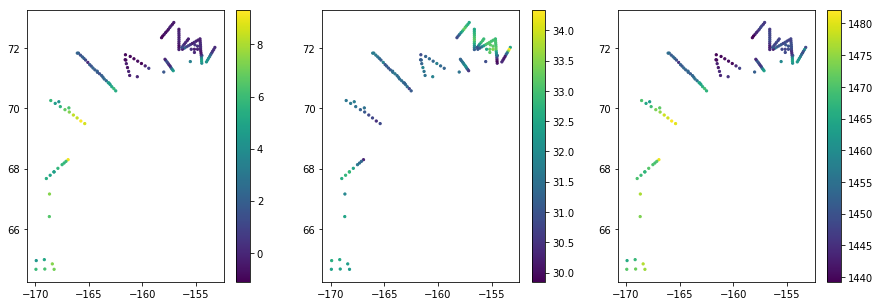

In [4]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.scatter(ctdCasts.lon, ctdCasts.lat, 5, c = ctdCasts.temp)
plt.colorbar();

plt.subplot(132)
plt.scatter(ctdCasts.lon, ctdCasts.lat, 5, c = ctdCasts.salinity)
plt.colorbar();

plt.subplot(133)
plt.scatter(ctdCasts.lon, ctdCasts.lat, 5, c = ctdCasts.c)
plt.colorbar();

In [7]:
sdRegion = ctdCasts.c[(ctdCasts.lon > -170) & (ctdCasts.lon < -159) & (ctdCasts.lat > 66) & (ctdCasts.lat < 72.5)]
print('Min: ' + str(min(sdRegion)) + '\n' +
'Mean: '+ str(np.mean(sdRegion))+ '\n' + 
'Max: ' +str(max(sdRegion))+ '\n' + 
'STDev: '+str(np.std(sdRegion)))

Min: 1439.2602631578948
Mean: 1458.6521946837663
Max: 1482.1106451612902
STDev: 12.75783934720982


Sensitivity to changes in sound speed, based on *Bodhold, 2002*

We can compute a new gain as a function of a change in the sound speed.
g = g<sub>0</sub>(c<sub>0</sub><sup>2</sup>/c<sup>2</sup>)

We'll use an example from SD1023, and assume c<sub>0</sub> is the mean calculated above.

In [6]:
G0 = 19.83
g0 = (10**(G0/10))
c0 = np.mean(sdRegion)
#if c is actually the max value found...
gmax = g0*((c0**2)/max(sdRegion)**2)
gmin = g0*((c0**2)/min(sdRegion)**2)
print(10*np.log10(gmax),10*np.log10(gmin))

19.69142246413402 19.946248295101423


The difference in the linear gain is the ratio of the squared sound speeds

In [7]:
print('The range of that ratio is '+str((c0**2)/max(sdRegion)**2) + ' to '+ str((c0**2)/min(sdRegion)**2))
print('The maximum value is '+ str((1-(c0**2)/max(sdRegion)**2)*100)+' %')
print('Which in dB change (assuming '+str(G0)+' from cal) is '+ str(10*np.log10(g0*(1+(1-(c0**2)/max(sdRegion)**2)))- 10*np.log10((10**(19.83/10)))))

The range of that ratio is 0.96859505258024 to 1.0271286174065148
The maximum value is 3.1404947419759965 %
Which in dB change (assuming 19.83 from cal) is 0.13429210289571358


With Sv, changes in g and equivalent beam angle cancel each other out with changes in sound speed.  As long as we correct EBA for the in situ sound speed, Sv should not be a concern.  Ok, now let's do this for the entire dataset from last summer, and we'll compare the averages.

# OS201701 CTD Data

Now I'll do the same thing, except for the OS201701 data, which has much greater coverage.

The CTD data hasn't gone through secondary processing, so I need to use the unesqo equation to determine sound speed.

In [8]:
# Equation for sound speed
def unesco_eq(S,T,P): # requires salinity (ppt), temperature (C), and pressure (bars)
        # The unesco equation for calculate sound speed based on
        C_00 = 1402.388;C_01 = 5.03830;C_02 = -5.81090*(10**-2);C_03 = 3.3432*(10**-4);C_04 = -1.47797*(10**-6);C_05 = 3.1419*(10**-9)
        C_10 = .153563;C_11 = 6.8999*(10**-4);C_12 = -8.1829*(10**-6);C_13 = 1.3632*(10**-7);C_14 = -6.126*(10**-10)
        C_20 = 3.126*(10**-5);C_21 = -1.7111*(10**-6);C_22 = 2.5986*(10**-8);C_23 = -2.5353*(10**-10);C_24 = 1.0415*(10**-12)
        C_30  = -9.7729*(10**-9);C_31 = 3.8513*(10**-10);C_32 = -2.3654*(10**-12)
        A_00 = 1.389;A_01 = -1.262*(10**-2);A_02 = 7.166*(10**-5);A_03 = 2.008*(10**-6);A_04 = -3.21*(10**-8)
        A_10 = 9.4742*(10**-5);A_11 = 1.2583*(10**-5);A_12 = -6.4928*(10**-8);A_13 = 1.0515*(10**-8);A_14 = -2.0142*(10**-10)
        A_20 = -3.9064*(10**-7);A_21 = 9.1061*(10**-9);A_22 = -1.6009*(10**-10);A_23 = 7.994*(10**-12)
        A_30 = 1.1*(10**-10);A_31 = 6.651*(10**-12);A_32 = -3.391*(10**-13)
        B_00 = -1.922*(10**-2);B_01 = -4.42*(10**-5)
        B_10 = 7.3637*(10**-5);B_11 = 1.795*(10**-7)
        D_00 = 1.727*(10**-3)
        D_10 = -7.9836*(10**-6)

        D_tp = D_00 + (D_10*P)
        B_tp = B_00 + (B_01*T) + ((B_10+(B_11*T))*P)
        A_tp = (A_00 + (A_01*T) + (A_02 * (T**2)) + (A_03 * (T**3)) + (A_04 * (T**4))) +\
                ((A_10 + (A_11*T) + (A_12*(T**2)) + (A_13*(T**3)) + (A_14*(T**4)))*P) +\
                ((A_20 + (A_21*T) + (A_22*(T**2)) + (A_23*(T**3))) * (P**2)) +\
                ((A_30 + (A_31*T) + (A_32*(T**2)))*(P**3))
        Cw_tp = (C_00 + (C_01*T) + (C_02*(T**2)) + (C_03*(T**3)) + (C_04*(T**4)) + (C_05*(T**5))) +\
                ((C_10 + (C_11*T) + (C_12*(T**2)) + (C_13*(T**3)) + (C_14*(T**4)))*P) + \
                ((C_20 + (C_21*T) + (C_22*(T**2)) + (C_23*(T**3)) + (C_24*(T**4)))*(P**2)) + \
                ((C_30 + (C_31*T) + (C_32*(T**2)))*(P**3))
        c = Cw_tp + (A_tp*S) + (B_tp*(S**(3/2))) + (D_tp*(S**2))
        return c

In [9]:
# Read in all of the .cnv files from the HLY
files = glob('../../data/ctdData/OS201701/*.cnv')
profile = fCNV(files[0])
print(profile.attributes)
print(profile.keys())

{'sbe_model': '9', 'LATITUDE': 67.91083333333333, 'LONGITUDE': -168.185, 'gps_datetime': 'Aug 06 2017  15:42:36', 'seasave': 'V 7.21d', 'instrument_type': 'CTD', 'nquan': '23', 'nvalues': '48', 'start_time': 'Aug 06 2017 15:42:36 [NMEA time, header]', 'bad_flag': '-9.990e-29', 'file_type': 'ascii', 'md5': '62274dce8ba16d13251c674bc6cc7301', 'datetime': datetime.datetime(2017, 8, 6, 15, 42, 36), 'filename': 'ctd001.cnv'}
['TEMP', 'TEMP2', 'scan', 'timeS', 'PRES', 'c0mS/cm', 'c1mS/cm', 'oxigenvoltage', 'sbeox1V', 'flECO-AFL', 'turbWETntu0', 'par', 'altM', 'PSAL', 'PSAL2', 'sigma_t', 'sigma_t', 'sbox0Mm/Kg', 'sbox1Mm/Kg', 'sbeox0PS', 'sbeox1PS', 'nbin', 'flag']


In [10]:
# For each file, lets pull out the location, and the average temp, salinity, fluorometer reading, 
# and seabird calculated sound speed from below 2 meters (saildrone draft is 1.94) to the bottom
lat = []
lon = []
dt = []
temp = []
sal = []
ss = []
ssMean = []
flo = []
pres = []
for file in files:
    profile = fCNV(file)
    lat.append(profile.attributes.get('LATITUDE'))
    lon.append(profile.attributes.get('LONGITUDE'))
    dt.append('gps_datetime')
    temp.append(np.mean(profile.data[0][profile.data[4] > 2]))
    sal.append(np.mean(profile.data[13][profile.data[4] > 2]))
    pres.append(np.mean(profile.data[4][profile.data[4] > 2]))
    flo.append(np.mean(profile.data[9][profile.data[4] > 2]))
    for i in range(len(profile.data[0][profile.data[4] > 2])):
        ss.append(unesco_eq(profile.data[13][profile.data[4] > 2][i],profile.data[0][profile.data[4] > 2][i],profile.data[4][profile.data[4] > 2][i]*.1))
    ssMean.append(np.mean(ss))
    ss= []
    
ctdCasts = pd.DataFrame({'lat':lat, 'lon':lon,'datetime':dt, 'temp':temp,'salinity':sal,'c':ssMean,'fluor':flo})
ctdCasts.head()

,lat,lon,datetime,temp,salinity,c,fluor
0,67.910833,-168.185000,gps_datetime,4.554944,32.160877,1465.707355,1.528342
1,70.211667,-167.790000,gps_datetime,4.884708,32.481150,1467.182350,0.911942
2,70.017500,-166.849833,gps_datetime,5.976154,32.282579,1471.454065,0.582713
3,70.018500,-166.851500,gps_datetime,6.205761,32.271516,1472.333897,0.622313
4,71.233333,-164.221667,gps_datetime,3.464717,32.055014,1460.578261,0.627617


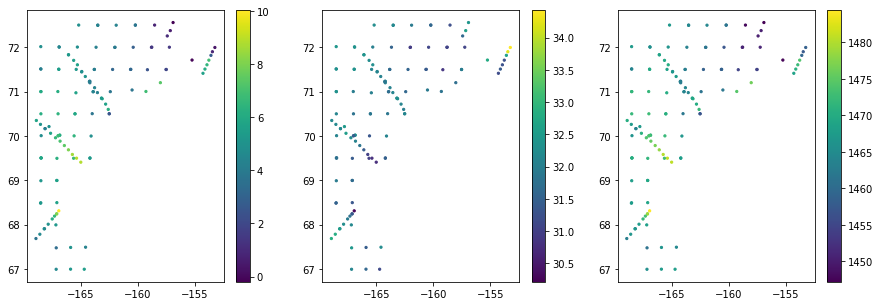

In [11]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.scatter(ctdCasts.lon, ctdCasts.lat, 5, c = ctdCasts.temp)
plt.colorbar();

plt.subplot(132)
plt.scatter(ctdCasts.lon, ctdCasts.lat, 5, c = ctdCasts.salinity)
plt.colorbar();

plt.subplot(133)
plt.scatter(ctdCasts.lon, ctdCasts.lat, 5, c = ctdCasts.c)
plt.colorbar();

In [12]:
sdRegion = ctdCasts.c[(ctdCasts.lon > -170) & (ctdCasts.lon < -159) & (ctdCasts.lat > 66) & (ctdCasts.lat < 72.5)]
print('For the entire survey: '+str(np.mean(ctdCasts.c))+
'\nFor the Saildrone Region: \nMin: ' + str(min(sdRegion)) + '\n' +
'Mean: '+ str(np.mean(sdRegion))+ '\n' + 
'Max: ' +str(max(sdRegion))+ '\n' + 
'STDev: '+str(np.std(sdRegion)))

For the entire survey: 1466.3632683655126
For the Saildrone Region: 
Min: 1454.6686674459686
Mean: 1467.7723679253054
Max: 1484.4228241274027
STDev: 5.469751095364438


In [13]:
G0 = 19.83
g0 = (10**(G0/10))
c0 = np.mean(sdRegion)
#if c is actually the max value found...
gmax = g0*((c0**2)/max(sdRegion)**2)
gmin = g0*((c0**2)/min(sdRegion)**2)
print(10*np.log10(gmax),10*np.log10(gmin))
print('The range of that ratio is '+str((c0**2)/max(sdRegion)**2) + ' to '+ str((c0**2)/min(sdRegion)**2))
print('The maximum value is '+ str((1-(c0**2)/max(sdRegion)**2)*100)+' %')
print('Which in dB change (assuming '+str(G0)+' from cal) is '+ str(10*np.log10(g0*(1+(1-(c0**2)/max(sdRegion)**2)))- 10*np.log10((10**(19.83/10)))))

19.73202168277708 19.907892458802415
The range of that ratio is 0.9776922402244631 to 1.018097206661694
The maximum value is 2.2307759775536895 %
Which in dB change (assuming 19.83 from cal) is 0.09581657297434276


# Just for fun, combined

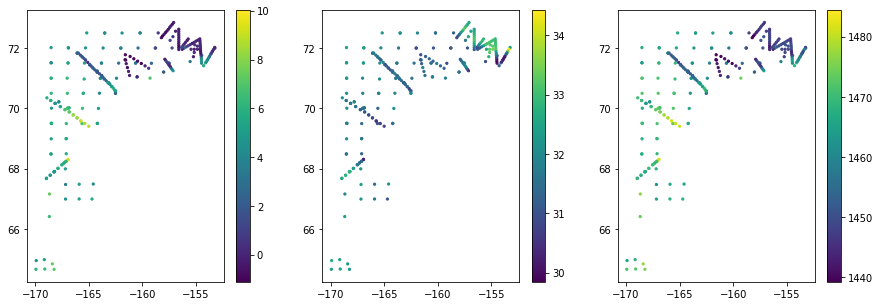

In [18]:
allCasts = pd.concat([ctdCasts,ctdCastsHly])
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.scatter(allCasts.lon, allCasts.lat, 5, c = allCasts.temp)
plt.colorbar();

plt.subplot(132)
plt.scatter(allCasts.lon, allCasts.lat, 5, c = allCasts.salinity)
plt.colorbar();

plt.subplot(133)
plt.scatter(allCasts.lon, allCasts.lat, 5, c = allCasts.c)
plt.colorbar();

In [19]:
sdRegion = allCasts.c[(allCasts.lon > -170) & (allCasts.lon < -159) & (allCasts.lat > 66) & (allCasts.lat < 72.5)]
print('For the entire survey: '+str(np.mean(allCasts.c))+
'\nFor the Saildrone Region: \nMin: ' + str(min(sdRegion)) + '\n' +
'Mean: '+ str(np.mean(sdRegion))+ '\n' + 
'Max: ' +str(max(sdRegion))+ '\n' + 
'STDev: '+str(np.std(sdRegion)))

For the entire survey: 1460.1215318819163
For the Saildrone Region: 
Min: 1439.2602631578948
Mean: 1464.534436596948
Max: 1484.4228241274027
STDev: 9.804495136287684
